<div style="display:flex;">
  <span style="margin-top:auto; margin-bottom:auto; margin-right:0.5em;"> Open notebook in binder: </span>
  <span style="margin-top:auto; margin-bottom:auto;"><a href="https://mybinder.org/v2/gh/jeromerg/filoc/master?filepath=examples%2Fexample_ml.ipynb"><img src="https://mybinder.org/badge_logo.svg" width="150"></a></span>
</div>


In [1]:
### Improve rendering with custom style
from IPython.core.display import HTML
with open( './custom.css', 'r' ) as f:
    display(HTML(f"<style>{f.read()}</style>"));

In [16]:
import sys
import itertools
import numpy as np
import pandas as pd
import torch
from   torch.autograd import Variable
import sklearn.datasets
import keras.utils
from concurrent.futures.thread import ThreadPoolExecutor
import sys
import traceback
import matplotlib.pyplot as plt
import seaborn as sns
import math

pd.set_option('display.max_rows', 10)

# <span class="filoc">filoc</span> in Machine Learning

<span class="filoc">filoc</span> is a simple yet powerful and scalable solution to:

- Prepare hyperparameters
- Schedule simulations
- Analyze results

It has the following advantages in comparison to existing solution like [neptune](https://neptune.ai/):

- No Server
- No Database
- Framework agnostic

## Example 

In this example, you will tune a [pytorch](https://pytorch.org/) model on the [IRIS database](https://en.wikipedia.org/wiki/Iris_flower_data_set).

The leading idea of <span class="filoc">filoc</span> is to use a file system, local or remote, to manage the entire life-cycle of your machine learning experience, from the definition of the simulation hyperparameters to the post-analysis.

In this example, we want to perform multiple simulations with various hyperparameters, in order to find the best model and the best training parameters. 

A reasonable file structure is to store the data of each simulation into a separate folders. Maybe something as follows:

![img](./img/tree_view.png)

Each simulation folder contains three categories of files:

- `hyperparams.json` : Contains the hyperparameters definition
- `state.json` : Stores the execution state of the simulation
- `epoch_xxx.json` :  Stores the result for the epoch `xxx`, where `xxx` is an integer

### Installing <span class="filoc">filoc</span>

First you need to install <span class="filoc">filoc</span>:

In [6]:
!pip install --upgrade filoc

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: filoc in /home/jerom/.local/lib/python3.8/site-packages (0.0.9)


### Importing <span class="filoc">filoc</span> 

Most of the time, you only need to import the `filoc(...)` function. This is the most *pythonic* way to use <span class="filoc">filoc</span>:

In [7]:
from filoc import filoc

<span class="post-remark"><code>filoc(...)</code> is a factory function that returns a <code>FilocContract</code> object, which is a kind of bi-directional adapter between a DataFrame and files defined in a structured manner.</span>

### Creating <span class="filoc">filoc</span>  instances

You use <span class="filoc">filoc</span> to read and write all three file groups `hyperparams.json`, `state.json` and the result files `epoch_xxx.json`

So you create three "filocs", one for each file group:

In [8]:
hyperparams_loc = filoc('./temp/iris/sim={sim:d}/hyperparameters.json', writable=True)
state_loc       = filoc('./temp/iris/sim={sim:d}/state.json'          , writable=True)
result_loc      = filoc('./temp/iris/sim={sim:d}/epoch_{epoch:d}.json', writable=True)

<span class="post-remark">The <code>filoc(...)</code> first argument defines the path, where you intend to read and write the files. It contains format placeholders, which are part of the data that are read or written.
</span>

<span class="post-remark">The <code>writable</code> flag enables the write access to the files. By default the access is read-only.</span>

Now let's prepare the training datasets and the model to train. The next three paragraphs are usual ML stuff... you won't need <span class="filoc">filoc</span> for that.

### Prepare datasets

1) Load the IRIS dataset:

In [3]:
iris = sklearn.datasets.load_iris()
print(f'X: {iris.data[0]}, y: {iris.target[0]}')

X: [5.1 3.5 1.4 0.2], y: 0


2) Convert target to [one-hot vectors](https://deepai.org/machine-learning-glossary-and-terms/one-hot-encoding) (and by the way convert to pytorch tensor):

In [4]:
all_X = torch.from_numpy(iris.data).type(torch.DoubleTensor)
all_y = torch.from_numpy(keras.utils.to_categorical(iris.target)).type(torch.DoubleTensor) # transform output label to one hot
print(f'all_y:{all_y[0].numpy()}')

all_y:[1. 0. 0.]


3) Shuffle and split dataset into training and validation subsets:

In [5]:
indexes = list(range(len(iris.data))); np.random.shuffle(indexes) # shuffle to randomly draw training and validation sets
train_X = Variable(all_X[indexes[:100]])
train_y = Variable(all_y[indexes[:100]])
valid_X = Variable(all_X[indexes[100:150]])
valid_y = Variable(all_y[indexes[100:150]])

print(f'Shapes: train_X={tuple(train_X.shape)}, valid_X={tuple(valid_X.shape)}, train_y={tuple(train_y.shape)}, valid_y={tuple(valid_y.shape)}')

### Preparing the model to train
Let's say, you want to train a two-layer feed-forward model with dropout:

In [9]:
class Model(torch.nn.Module):
    """
    Model Input : Flower caracteristics (4 continuous features)
    Model Output: Iris class (3 classes, one-hot vector) 
    """
    def __init__(self, layer1_size, layer2_size, dropout_prob):
        super(Model,self).__init__()
        self.l1      = torch.nn.Linear(4, layer1_size)
        self.l2      = torch.nn.Linear(layer1_size, layer2_size)
        self.l3      = torch.nn.Linear(layer2_size, 3)
        self.dropout = torch.nn.Dropout(p=dropout_prob)
    def forward(self, x):
        sigmoid = torch.nn.Sigmoid()
        relu    = torch.nn.ReLU()
        y       = relu(self.l1(x))
        y       = self.dropout(y)
        y       = relu(self.l2(y))
        y       = self.dropout(y)
        y       = sigmoid(self.l3(y))
        return y

This model has 3 hyperparameters: `layer1_size`, `layer2_size`, `dropout_prob`. We will perform a simple stochastic gradient descent with constant learning rate, so we get a fourth hyperparameter: `learning_rate`.

Together you get four hyperparameters to tune:
<table>
      <tr><td>layer1_size  </td><td>Size of the first hidden layer </td></tr>
      <tr><td>layer2_size  </td><td>Size of the second hidden layer</td></tr>
      <tr><td>dropout_prob </td><td>Dropout probability            </td></tr>
      <tr><td>learning_rate</td><td>Constant learning rate         </td></tr>
</table>


### Creating the simulation hyperparameter sets

To tune the hyperparameters, you will perform a basic [grid search](https://deepai.org/machine-learning-glossary-and-terms/hyperparameter) on the four hyperparameters. 

You first need to define the points of the grid on each dimension:

In [10]:
layer1_sizes   = [9, 27, 81]
layer2_sizes   = [9, 27, 81]
dropout_probs  = [0, 0.25, 0.5]
learning_rates = [0.01, 0.001]

Then you build the cartesian product and pack the result into a DataFrame:

In [11]:
sims_hyperparameters = []
for sim, (layer1_size, layer2_size, dropout_prob, learning_rate) in enumerate(itertools.product(layer1_sizes, layer2_sizes, dropout_probs, learning_rates)):
    sims_hyperparameters.append({
        'sim'           : sim, 
        'layer1_size'   : layer1_size, 
        'layer2_size'   : layer1_size, 
        'dropout_prob'  : dropout_prob, 
        'learning_rate' : learning_rate
    })
sims_hyperparameters = pd.DataFrame(sims_hyperparameters)
sims_hyperparameters

,sim,layer1_size,layer2_size,dropout_prob,learning_rate
0,0,9,9,0.00,0.010
1,1,9,9,0.00,0.001
2,2,9,9,0.25,0.010
3,3,9,9,0.25,0.001
4,4,9,9,0.50,0.010
...,...,...,...,...,...
49,49,81,81,0.00,0.001
50,50,81,81,0.25,0.010
51,51,81,81,0.25,0.001
52,52,81,81,0.50,0.010


It generated 54 hyperparameters sets ( 2 x 3 x 3 x 3)

### Saving the simulation hyperparameter sets

Now you will use <span class="filoc">filoc</span> to save each simulation hyperparameters set into its dedicated hyperparameter file... 

It is actually a piece of cake:

In [12]:
hyperparams_loc.write_contents(sims_hyperparameters)

<span class="post-remark"><code>FilocContract.write_contents(...)</code> created all the 54 hyperparameters files at once! It substituted the <code>sim</code> variable defined in the filoc path <code>./temp/iris/sim={sim:d}/hyperparameters.json</code>  by the <code>sim</code> value defined in the <code>sim_hyperparameters</code> list, then created the files and filled them with the remaining variables of the object.
</span>

Let's check the created files with the terminal `ls` command:

In [13]:
! ls ./temp/iris/*/*

'./temp/iris/sim=0/hyperparameters.json'
'./temp/iris/sim=1/hyperparameters.json'
'./temp/iris/sim=10/hyperparameters.json'
'./temp/iris/sim=11/hyperparameters.json'
'./temp/iris/sim=12/hyperparameters.json'
'./temp/iris/sim=13/hyperparameters.json'
'./temp/iris/sim=14/hyperparameters.json'
'./temp/iris/sim=15/hyperparameters.json'
'./temp/iris/sim=16/hyperparameters.json'
'./temp/iris/sim=17/hyperparameters.json'
'./temp/iris/sim=18/hyperparameters.json'
'./temp/iris/sim=19/hyperparameters.json'
'./temp/iris/sim=2/hyperparameters.json'
'./temp/iris/sim=20/hyperparameters.json'
'./temp/iris/sim=21/hyperparameters.json'
'./temp/iris/sim=22/hyperparameters.json'
'./temp/iris/sim=23/hyperparameters.json'
'./temp/iris/sim=24/hyperparameters.json'
'./temp/iris/sim=25/hyperparameters.json'
'./temp/iris/sim=26/hyperparameters.json'
'./temp/iris/sim=27/hyperparameters.json'
'./temp/iris/sim=28/hyperparameters.json'
'./temp/iris/sim=29/hyperparameters.json'
'./temp/iris/sim=3/hyperparameters.js

Let's check a single file:

In [14]:
! cat ./temp/iris/sim=23/hyperparameters.json

{
  "layer1_size": 27,
  "layer2_size": 27,
  "dropout_prob": 0.5,
  "learning_rate": 0.001
}

### Preparing the state file

During a simulation campaign you need to manage the execution state of each simulation enables in order to:

- Concurrently execute simulations(concurrent safe)
- Be resilient in case of problems
- Monitor the progress of your simulation campaign

In this example, you will work with four states:

state      | description
-----------|--------------------------------------
init       | simulation is ready to be executed
running    | simulation is currently executed
failed     | simulation has failed and stopped
succeeded  | simulation has ended properly

With <span class="filoc">filoc</span>, it is a piece of cake to initialize the state files:

In [15]:
sim_states = sims_hyperparameters[['sim']].copy()
sim_states['state'] = 'init'

with state_loc.lock():
    state_loc.write_contents(sim_states)

<span class="post-remark">Here, the `write_contents(...)` call has been packed into a <code>state_loc.lock()</code> with-block. It ensures that no other processes currently read from nor write to the state files.
</span>

The locking implementation is relative simple and works only against other `state_loc.lock()` protected access by other threads/processes/machines.

### Preparing the simulation script

In practice, you will rather perform a simulation by executing a python script separately. But in this example, we pack the training in a single function and execute it in multiple threads:

In [16]:
def train_and_validate(sim):
    # !!! LOAD HYPERPARAMETERS !!!
    hyps = hyperparams_loc.read_content(sim = sim)    

    model    = Model(hyps.layer1_size, hyps.layer2_size, hyps.dropout_prob).double()
    loss_fun = torch.nn.BCELoss(reduction='mean')
    opt      = torch.optim.SGD(model.parameters(), lr=hyps.learning_rate)

    for epoch in range(10000 + 1):  # +1 to save last result
        # train
        train_y_pred = model(train_X)
        train_loss   = loss_fun(train_y_pred, train_y)    
        train_acc    = (torch.argmax(train_y_pred, dim=1) == torch.argmax(train_y, dim=1)).sum().item() / len(train_y)
        opt.zero_grad()
        train_loss.backward() # back prop
        opt.step()

        # validate and save results (every 100 epoch)
        if epoch % 100 == 0:
            with torch.no_grad():
                valid_y_pred = model(valid_X)
                valid_loss   = loss_fun(valid_y_pred, valid_y)    
                valid_acc    = (torch.argmax(valid_y_pred, dim=1) == torch.argmax(valid_y, dim=1)).sum().item() / len(valid_y)

                # !!! WRITE EPOCH RESULT !!!
                result_loc.write_content({
                    'sim'        : sim,
                    'epoch'      : epoch,
                    'train_loss' : train_loss.item(),
                    'train_acc'  : train_acc,
                    'valid_loss' : valid_loss.item(),
                    'valid_acc'  : valid_acc,
                })

Here you used <span class="filoc">filoc</span> at two places: 

- `read_content(...)` reads the simulation hyperparameters at the beginning
- `write_content(...)` writes the epoch result every 100 epochs

By default, the <code>filoc(...)</code> factory returns a <code>FilocContract</code> with a so-called <strong>pandas front-end</strong>. With that front-end: 

- <code>read_content(...)</code> returns a a pandas <code>Series</code>
- <code>read_contents(...)</code> returns a a pandas <code>DataFrame</code>
- <code>write_content(...)</code> accepts either a pandas <code>Series</code> or a <code>dict</code>
- <code>write_contents(...)</code> accepts either a pandas <code>DataFrame</code> or a list of <code>dict</code>. 

But you can also configure <code>filoc(...)</code> to use the <strong>json frontend</strong>, which handle plain python objects, or you may also implement your own frontend.


Remark: If you don't want to reference <span class="filoc">filoc</span> in your machine learning script, just replace the `read_content(...)` and `write_content(...)` calls as follows:

<span class="filoc">filoc</span> | with json 
--------------------------------------|-----------
`hyps = hyperparams_loc.read_content(sim = sim)` | `with open(f'./temp/iris/sim={sim}/hyperparameters.json') as f: hyps = json.loads(f)`
`result_loc.write_content(result)` | `with open(f'./temp/iris/sim={sim}/epoch_{epoch}.json', 'w') as f: json.dumps(result, f)`


### Prepare parallelization

To parallelize the training, we need a small piece of code, that look at the next simulation to execute. This piece of code must be concurrent safe, as it will be executed in multiple threads, processes or machines:

In [17]:
def book_next_simulation():
    with state_loc.lock():
        sim_states_all  = state_loc.read_contents()
        if len(sim_states_all) == 0: 
            return None  # No sim to execute
        
        sim_states_init = sim_states_all.query("state == 'init'")
        if len(sim_states_init) == 0: 
            return None  # No sim to execute
        
        sim_state = sim_states_init.iloc[0, :].copy()
        sim_state.state = 'running'
        state_loc.write_content(sim_state)
        return sim_state.sim  # returns the sim id

The use of `state_loc.lock()` ensures that only one thread at a time can book a simulation.

You finally need a loop to process simulations in series in each thread:

In [18]:
def process_simulations(executor_name):
    try:
        while True:
            sim = book_next_simulation()
            if sim is None:
                print(f'{executor_name}: no simulation to process')
                return
            print(f'{executor_name}: processing simulation {sim}')
            try:
                train_and_validate(sim)
                state_loc.write_content({'sim': sim, 'state': 'succeeded'})
            except:
                state_loc.write_content({'sim': sim, 'state': 'failed'})
                
            print(f'{executor_name}: processed  simulation {sim}')
    except:
        traceback.print_exc()
        

And now we can start a few executors, that will concurrently execute the simulations:

In [19]:
with ThreadPoolExecutor() as executor:
    executor.submit(process_simulations, "executor1")
    executor.submit(process_simulations, "executor2")
    executor.submit(process_simulations, "executor3")
    executor.submit(process_simulations, "executor4")    

executor2: no simulation to process
executor1: processing simulation 0
executor4: processing simulation 0
executor3: processing simulation 1
executor1: processed  simulation 0
executor1: processing simulation 2
executor4: processed  simulation 0
executor4: processing simulation 3
executor3: processed  simulation 1
executor3: processing simulation 4
executor1: processed  simulation 2
executor1: processing simulation 5
executor4: processed  simulation 3
executor4: processing simulation 6
executor3: processed  simulation 4
executor3: processing simulation 7
executor4: processed  simulation 6
executor4: processing simulation 8
executor3: processed  simulation 7
executor3: processing simulation 9
executor1: processed  simulation 5
executor1: processing simulation 10
executor4: processed  simulation 8
executor4: processing simulation 11
executor3: processed  simulation 9
executor3: processing simulation 12
executor1: processed  simulation 10
executor1: processing simulation 13
executor3: pro

All simulations were performed concurrently 4 by 4!

### Monitoring executions

During the execution, you can use <span class="filoc">filoc</span> to monitor the execution state. In practice we would do that in another notebook.

Here is how it works:

In [2]:
from filoc import filoc
mon_state_loc = filoc('./temp/iris/sim={sim:d}/state.json', timestamp_col='modified')

<span class="post-remark">`timestamp_col='modified'` adds the *modified* column to the result. It contains the file timestamp, so that we can monitor when the state last changed! This information is interesting to detect issues, like simulations that failed without changing to the expected `failed` state.</span>
    
Let's see how it looks like "after" the execution of all simulations:

In [3]:
df_state = mon_state_loc.read_contents()

df_state.head(10)

,state,modified,sim
0,succeeded,2020-09-28 19:40:02.020,0
1,succeeded,2020-09-28 19:40:02.550,1
2,succeeded,2020-09-28 19:40:49.140,2
3,succeeded,2020-09-28 19:40:49.440,3
4,succeeded,2020-09-28 19:40:50.080,4
5,succeeded,2020-09-28 19:41:42.330,5
6,succeeded,2020-09-28 19:41:33.250,6
7,succeeded,2020-09-28 19:41:33.990,7
8,succeeded,2020-09-28 19:42:20.320,8
9,succeeded,2020-09-28 19:42:21.200,9


If you need to filter by state, you can simply use the DataFrame filter functionalities. For example:

In [ ]:
df_state.query('state == "failed"')

### Analyzing results

<span class="filoc">filoc</span> allows us to seamlessly analyze the simulations, namely during and after the execution. Look how it works.
We first create a new `FilocContract` that joins all file contents together:

In [5]:
analysis_loc = filoc({
  'hyp'    : './temp/iris/sim={sim:d}/hyperparameters.json',
  'state'  : './temp/iris/sim={sim:d}/state.json',
  'result' : './temp/iris/sim={sim:d}/epoch_{epoch:d}.json',    
}, cache_locpath='temp/cache/iris/cache.bin')

<span class="post-remark">By feeding `filoc(...)` with a dictionary, we build a composite `FilocContract`, which is able to work with multiple files groups. By default, <span class="filoc">filoc</span> will join the file entries based on the variables in the path name</span>

<span class="post-remark">`cache_locpath` is used to improve the processing in the case of a great amount of files to process, especially if the files are store on a remote file system</span>

Let's see how it looks like:

In [7]:
df = analysis_loc.read_contents()

In [9]:
df

,index.sim,index.epoch,hyp.layer1_size,hyp.layer2_size,hyp.dropout_prob,hyp.learning_rate,state.state,result.train_loss,result.train_acc,result.valid_loss,result.valid_acc
0,0,0,9,9,0.0,0.010,succeeded,0.710793,0.32,0.695948,0.36
1,0,100,9,9,0.0,0.010,succeeded,0.613345,0.56,0.596848,0.52
2,0,200,9,9,0.0,0.010,succeeded,0.601427,0.67,0.595348,0.64
3,0,300,9,9,0.0,0.010,succeeded,0.573060,0.63,0.566490,0.56
4,0,400,9,9,0.0,0.010,succeeded,0.541517,0.68,0.537070,0.64
...,...,...,...,...,...,...,...,...,...,...,...
5449,53,9600,81,81,0.5,0.001,succeeded,0.341565,0.75,0.367922,0.74
5450,53,9700,81,81,0.5,0.001,succeeded,0.324613,0.77,0.361700,0.78
5451,53,9800,81,81,0.5,0.001,succeeded,0.354484,0.73,0.392643,0.66
5452,53,9900,81,81,0.5,0.001,succeeded,0.332840,0.77,0.360932,0.74


<span class="post-remark">You get a join table with the whole information of the simulation campaign!! The column names are prefixed with the the key provided in the definition dictionary. The variables <code>sim</code> and <code>index</code> have been prefixed by <code>index.</code>, because they are join variables, used to join all tables together, by default.</span>

The result is a kind of denormalized [fact table](https://en.wikipedia.org/wiki/Fact_table) about the simulations, that contains all the information. You can slice and dice the pandas DataFrame to analyze the result!

Example 1: show the time evolution of accuracy for each simulation:

First, let's get rough overview about all 54 simulations:

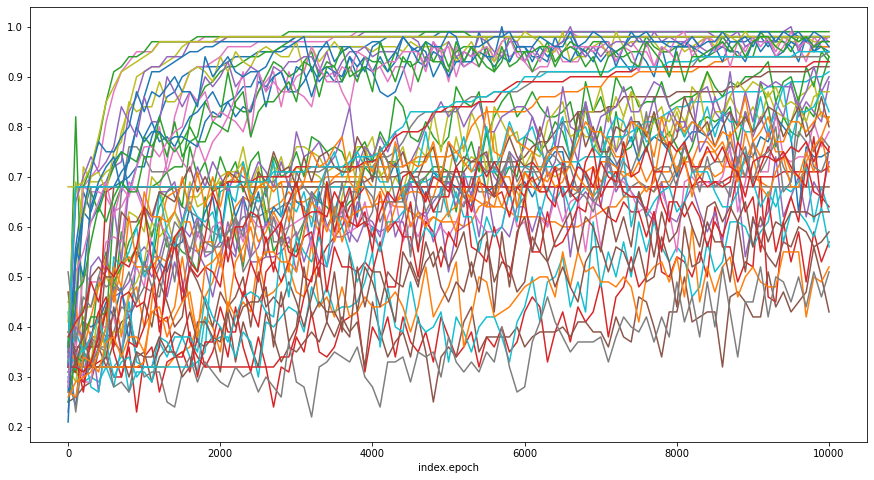

In [14]:
plt.rcParams['figure.figsize'] = [15, 8]
ax = plt.gca()
df.groupby(by='index.sim').plot(x='index.epoch', y='result.train_acc', ax=ax, legend=None);
#df.plot(x='index.epoch', y='result.valid_acc', ax=ax);

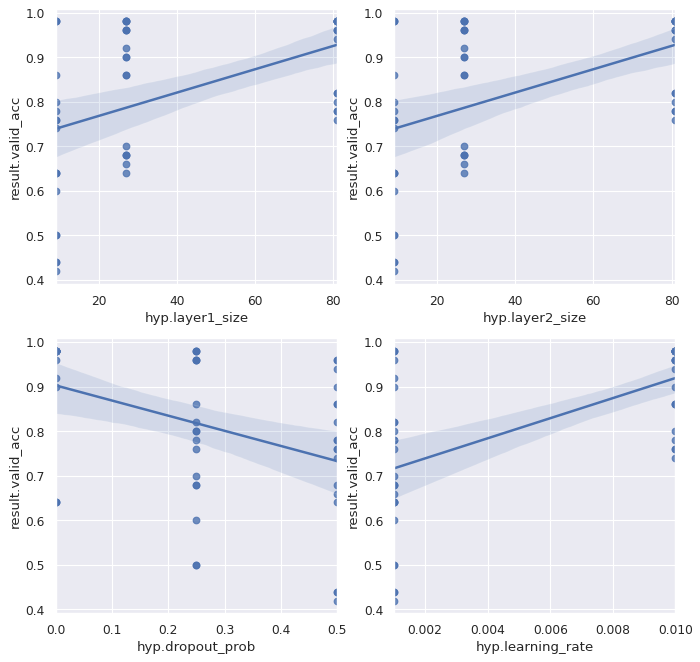

In [24]:
df_epoch = df[df['index.epoch'] == 10000]

hyps = ['hyp.layer1_size', 'hyp.layer2_size', 'hyp.dropout_prob', 'hyp.learning_rate']
len_width  = 2
len_height = 2

sns.set(color_codes=True)
fig = plt.figure(figsize=(10,10), dpi= 80)
for idx, hyp in enumerate(hyps):
    fig.add_subplot(len_height, len_width, idx+1)
    sns.regplot(x=hyp, y="result.valid_acc", data=df_epoch);

We can visualize the training accuracy vs. the validation accuracy for a single simulation, in order to detect overfitting and underfitting:

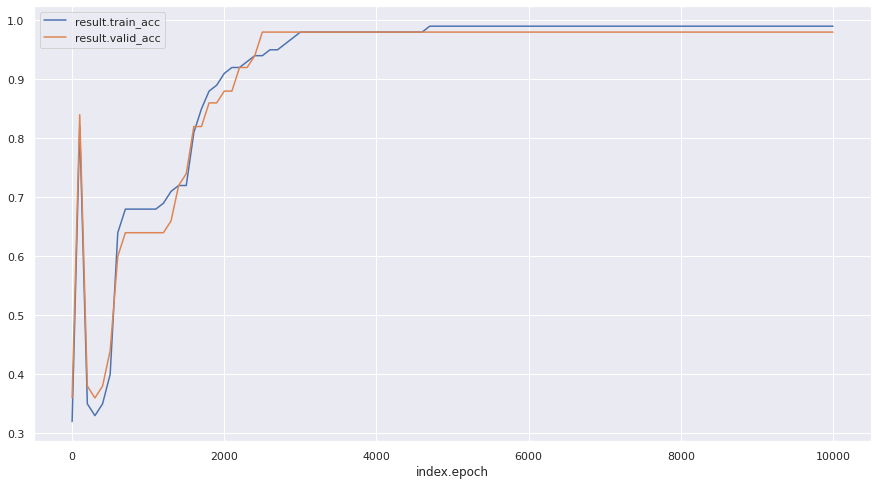

In [25]:
ax = plt.gca()
df1 = df[df["index.sim"] == 12]
df1.plot(x='index.epoch', y='result.train_acc', ax=ax)
df1.plot(x='index.epoch', y='result.valid_acc', ax=ax);

**Work in progress: ToDos:**
- Readme Doc
- API Doc 
- Improve file locking
- Test and fix join case: "/{a}/{b}/c.json" and "/{b}/{a}/d.json"
- Introduce flag "immutable=True" to speed-up cache mechanism (avoid to check file timestamp on file system)
- Introduce logging/print possibilities
    - a.o. Logging of edited files
- Feature: File watcher / syncer
- Feature: Excel File watcher / binder